In [2]:
%pip install -U -q pandas pyarrow scikit-learn seaborn tqdm mlflow

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\rkizm\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\~yarrow\\arrow.dll'
Consider using the `--user` option or check the permissions.



In [ ]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%0.4f' % x)

import pyarrow
from tqdm.auto import tqdm
tqdm.pandas()

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

c:\Users\rkizm\miniconda3\envs\MLOPS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import mlflow

mlflow.set_experiment('experiment-01')

<Experiment: artifact_location='file:///d:/Rustem/2_Education/7_Data_science/6_MLOps/02-experiment-tracking/mlruns/956066750265426875', creation_time=1718321909154, experiment_id='956066750265426875', last_update_time=1718321909154, lifecycle_stage='active', name='experiment-01', tags={}>

# Reading the data

In [3]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df

In [4]:
df = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df_val = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [5]:
dv = DictVectorizer()

In [6]:
train_dicts = df[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
y_train = df.duration.values

# Training a model

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')

Train RMSE: 7.649261929201487


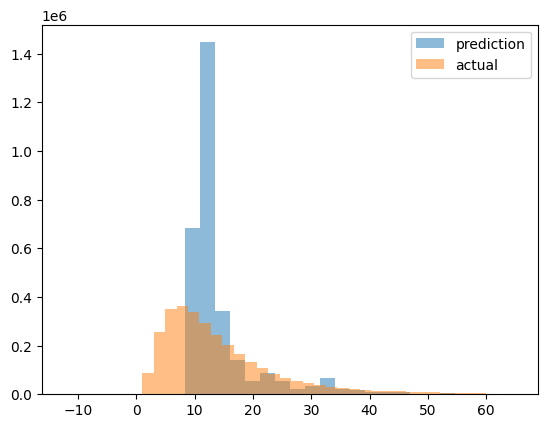

In [13]:
plt.hist(y_pred, bins=30, alpha=0.5, label='prediction')
plt.hist(y_train, bins=30, alpha=0.5, label='actual')

plt.legend()
plt.show()

In [7]:
val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values


In [ ]:
y_pred = lr.predict(X_val)
print(f'Val RMSE: {mean_squared_error(y_val, y_pred, squared=False)}')

In [ ]:
import pickle

with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

# MLFlow experiments

In [20]:
with mlflow.start_run():

    mlflow.set_tag('model', 'Lasso')
    mlflow.log_param('train-data', 'yellow_tripdata_2023-01')
    mlflow.log_param('valid-data', 'yellow_tripdata_2023-02')

    alpha = 0.005
    mlflow.log_param('alpha', alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_train)

    train_rmse = mean_squared_error(y_train, y_pred, squared=False)
    print(f'Lasso train RMSE: {train_rmse}')

    y_pred = lr.predict(X_val)
    valid_rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(f'Lasso val RMSE: {valid_rmse}')
    mlflow.log_metric('rmse', valid_rmse)

    mlflow.log_artifact(local_path = "models/lin_geg.bin", artifact_path = "models_pickle/")

Lasso train RMSE: 7.869421580205274
Lasso val RMSE: 8.005053100655111


In [23]:
with open('models/lasso.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

# XGBoost experiment

In [10]:
# %pip install -U -q xgboost hyperopt

Note: you may need to restart the kernel to use updated packages.


In [8]:
import xgboost as xgb

In [11]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [12]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [13]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

In [17]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor):

    with mlflow.start_run():

        mlflow.log_param('train-data', 'yellow_tripdata_2023-01')
        mlflow.log_param('valid-data', 'yellow_tripdata_2023-02')
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
        
        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)       

2024/06/14 01:17:49 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/06/14 01:18:03 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
